# Cat vs Dog Discriminator

Building a model that discriminates between images of cat and dogs using a convnet on a small dataset with augmentation, transfer learning and fine tuning.

Original dataset can be found [here](https://www.kaggle.com/c/dogs-vs-cats/data)

Note that this notebook relies on the outputs of `cats_v_dogs_prep.sh` file.

In [394]:
# import modules
import re
import pickle
import numpy as np
import pandas as pd
import cv2
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

In [240]:
# plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

In [4]:
# set up an image generators
img_generator = {
    'validation': ImageDataGenerator(rescale=1./255),
    'train': ImageDataGenerator(
        rescale=1./255, # scale to range 0-1
        # AUGMENTATION
        rotation_range=40,
        width_shift_range=0.2, 
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
}

active_generator = {}
for segment in ['train','validation']:
    active_generator[segment] = img_generator[segment].flow_from_directory(
        'datasets/cats_v_dogs/subset/{}/'.format(segment),
        target_size=(150, 150), # same as input shape in the model
        batch_size=20,
        class_mode='binary'
    )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
# LOADING A PRE-TRAINED MODEL
# trying the VGG16 convulutional base instead
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
conv_base.trainable = True
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [22]:
# FINE TUNING
# set last 3 layers to trainable
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1': # set trainable from here
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
# define the top layer
model = models.Sequential()
model.add(conv_base) # convolutional base
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [27]:
# compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc']
)

# train
model_perf = model.fit_generator(
    active_generator['train'],
    steps_per_epoch=100,
    epochs=100,
    validation_data=active_generator['validation'],
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 539s - loss: 0.5653 - acc: 0.6965 - val_loss: 0.3794 - val_acc: 0.8310

In [242]:
mph = model_perf.history
model.save('models/cats_v_dogs_classifier.h5') # save the model
pickle.dump(mph, open("models/cats_v_dogs_classifier_perf.p", "wb")) # save training history

In [250]:
# plot metrics

line_type = {
    'train': dict(
        color='grey',
        width=1,
        dash='dot'
    ),
    'validation': dict(
        color='orange',
        width=4
    )
}

fig = tools.make_subplots(
    rows=2, 
    cols=1, 
    shared_xaxes=True, 
    shared_yaxes=False
)

epoch_range = [i for i in range(100)]
i = 0
for m in ['acc','loss']:
    
    i += 1
    
    if m == 'acc':
        legend_display = True
    else:
        legend_display = False
    
    for sub in ['train','validation']:
        
        if sub == 'train':
            history_target = m
        else:
            history_target = 'val_{}'.format(m)
            
        fig.append_trace({
            'x': epoch_range,
            'y': mph[history_target],
            #'type': 'scatter',
            'name': sub,
            'legendgroup': sub,
            'yaxis': dict(title=m),
            'line': line_type[sub],
            'showlegend': legend_display
        }, i, 1)

fig['layout'].update(
    height=800, 
    width=1000, 
    xaxis1 = dict(title='Epoch'),
    yaxis1 = dict(title='Accuracy', tickformat=".0%"),
    yaxis2 = dict(title='Loss', tickformat=".0%"),
    title='CNN Performance'
)
iplot(fig)    

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]



Perhaps 10 or so epochs would have been enough, there appears to be a little overfitting happening.

In [359]:
# checking out some images
img_path = 'datasets/cats_v_dogs/subset/test/cat/cat.10902.jpg'
img = image.load_img(img_path, target_size=(150, 150)) 
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255.

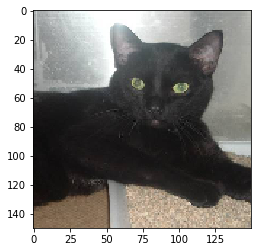

In [360]:
# raw image
plt.imshow(img_tensor[0])
plt.show()

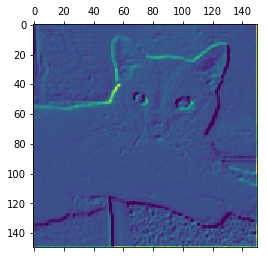

In [345]:
# feature map extraction
layer_outputs = [layer.output for layer in model.layers[0].layers] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
#print(activations[2].shape)
plt.matshow(activations[1][0, :, :, 0], cmap='viridis') # second layer
plt.show()

In [357]:
# identifying the location of the object of interest
img_tensor_pp = preprocess_input(img_tensor_raw)
preds = model.predict(img_tensor_pp)
#print('Predicted:', decode_predictions(preds, top=3)[0])

In [368]:
# detecting location of the object of interest
img = image.load_img(img_path, target_size=(224, 224)) # VGG was trainied on images that size
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor = preprocess_input(img_tensor)
vgg_model = VGG16(weights='imagenet')
preds = vgg_model.predict(img_tensor)
decode_predictions(preds, top=3)[0]

24576/35363 [===================>..........] - ETA: 0s

[('n02124075', 'Egyptian_cat', 0.74487573),
 ('n02123045', 'tabby', 0.075315423),
 ('n02123597', 'Siamese_cat', 0.037904937)]

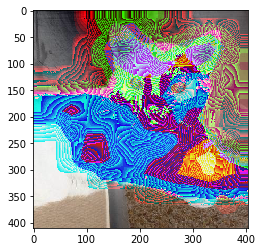

In [411]:
# plotting
target_out = vgg_model.output[:, np.argmax(preds[0])]
last_conv_layer = vgg_model.get_layer([l.name for l in vgg_model.layers if re.match(r'block\d_conv',l.name)][-1])
grads = K.gradients(target_out, last_conv_layer.output)[0] 
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([vgg_model.input],[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(last_conv_layer.get_config()['filters']):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
img = cv2.imread(img_path)
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.8 + img
plt.imshow(superimposed_img)
plt.show()